# Build a Brand Recognition model

1. Train a convnet from scratch
2. Train a classifier using a pre-trained imagenet model


In [1]:
%pylab inline

import seaborn as sns

import warnings
warnings.filterwarnings("ignore", message="Palette images")

Populating the interactive namespace from numpy and matplotlib


### Build a convnet from scratch

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import EarlyStopping, LearningRateScheduler

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense, InputLayer, Add

Using TensorFlow backend.


In [4]:
from CLR import clr_callback

##### Playing with image augmentation

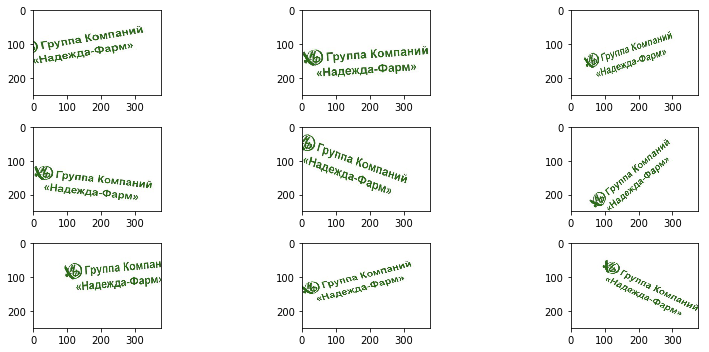

In [37]:
pic = './TargetLogos/train/19/5.jpg'


datagen = ImageDataGenerator(
         rescale=1/255.,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.6,
        zoom_range=0.2,
        fill_mode='nearest',
         data_format='channels_last',
)

img = load_img(pic)  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
plt.figure(figsize=(12,5))
for batch in datagen.flow(x, batch_size=1,):
    if i >= 9:
        break  # otherwise the generator would loop indefinitely
    plt.subplot(331 + i)
    plt.imshow(array_to_img(batch[0]))
    i += 1
plt.tight_layout()
plt.show()

##### Specifying a conv model

In [134]:
nW = nH = 256
nC = 3
nClasses = 38

In [135]:
def add_conv_layer(model, n_filters, filter_sizes, pool_sizes, batchnorm=True):
    '''
    A layer with 1 convolution, batchnorm and pooling
    '''
    model.add(Conv2D(n_filters, filter_sizes))
    model.add(Activation('relu'))
    if batchnorm:
        model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=pool_sizes))
    return model
              

def add_conv_block(model, n_filters, filter_sizes, pool_sizes, batchnorm=True, second_layer_multiplier=2):
    '''
    A block with 2 convolutions, 1 batchnorm and 1 pooling
    '''
    model.add(Conv2D(n_filters, filter_sizes))
    model.add(Activation('relu'))
    if batchnorm:
        model.add(BatchNormalization())
    model.add(Conv2D(n_filters * second_layer_multiplier, filter_sizes))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_sizes))
    return model

In [136]:
model = Sequential()
model.add(InputLayer(input_shape=(nW, nH, nC)))

model = add_conv_layer(model, 16, (3,3), (2,2), True, )
model = add_conv_layer(model, 32, (3,3), (2,2), True, )
model = add_conv_layer(model, 64, (3,3), (2,2), True, )
model = add_conv_layer(model, 128, (3,3), (2,2), True)
model = add_conv_layer(model, 128, (3,3), (2,2), True)

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nClasses, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [137]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 254, 254, 16)      448       
_________________________________________________________________
activation_90 (Activation)   (None, 254, 254, 16)      0         
_________________________________________________________________
batch_normalization_38 (Batc (None, 254, 254, 16)      64        
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 125, 125, 32)      4640      
_________________________________________________________________
activation_91 (Activation)   (None, 125, 125, 32)      0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 125, 125, 32)      128       
__________

##### Set image augmentation

In [138]:
import os

In [139]:
# get list of class names
# import pandas as pd
# classes = pd.read_excel('./aws/scripts/new_tsp_bonuses_data.xlsx',)['brand_name'].tolist()
classes = os.listdir('./TargetLogos/train/')
len(classes)

38

In [140]:
batch_size = 64
train_dir = './TargetLogos/train/'
test_dir = './TargetLogos/test/'

# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.21,
        height_shift_range=0.21,
        zoom_range=0.25,
        fill_mode='nearest',
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.21,
        height_shift_range=0.21,
        zoom_range=0.25,
        fill_mode='nearest',)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir,  # this is the target directory
        target_size=(nW, nH),  # all images will be resized to 150x150
        batch_size=batch_size,
        classes=classes,
        class_mode='categorical')  # since we use binary_crossentropy loss, we need binary labels

# this is a similar generator, for validation data
validation_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(nW, nH),
        batch_size=batch_size,
        classes=classes,
        class_mode='categorical')


Found 600 images belonging to 38 classes.
Found 215 images belonging to 38 classes.


##### Train the net

In [142]:
earlystopper = EarlyStopping(monitor='val_acc', patience=10, verbose=1, min_delta=0.001)
lr_scheduler = clr_callback.CyclicLR(base_lr=0.001, max_lr=0.01, step_size=10,)
callbacks = [
    earlystopper,
    lr_scheduler,
    ]

In [143]:
N_EPOCH = 300
train_steps = 600 // batch_size
val_steps = 215 // batch_size

In [215]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_steps,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=val_steps)
# model.save_weights('first_try.h5')  # always save your weights after training or during training

Epoch 1/1
8/9 [=========================>....] - ETA: 0s - loss: 13.3478 - acc: 0.1719

ValueError: Error when checking input: expected vgg16_input to have shape (244, 244, 3) but got array with shape (256, 256, 3)

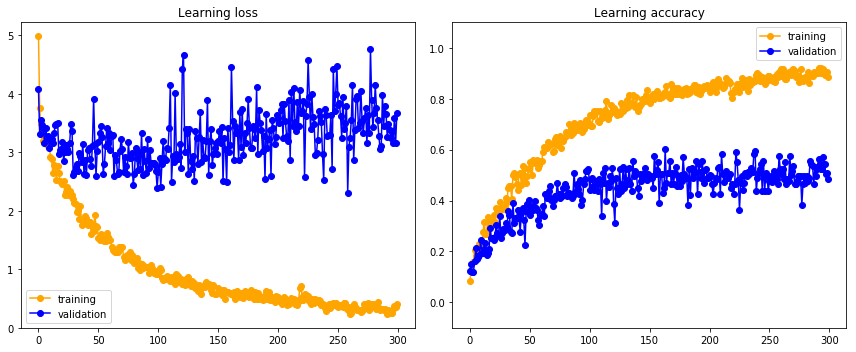

In [145]:
x = [i for i in range(len(history.epoch))]
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Learning loss')
plt.plot(x, history.history['loss'], '-o', color='orange', label='training')
plt.plot(x, history.history['val_loss'], '-o', color='blue', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Learning accuracy')
plt.plot(x, history.history['acc'], '-o', color='orange', label='training')
plt.plot(x, history.history['val_acc'], '-o', color='blue', label='validation')
plt.axis(ymin=-0.1, ymax=1.1)
plt.legend()
plt.tight_layout()
plt.show()

In [146]:
!python3 /data/home/akbds/.local/lib/python3.5/site-packages/telegram_send.py 'Done training the model'

> Conclusions:
- hard to achieve 50% accuracy on validation
- model produces high overfit
- simpler models such as conv layers instead of conv blocks and smaller input sizes performing better
- accuracy level is not enough for a production bot

### Build a classifier on top of a pre-trained model

Try several strategies when dataset is small and not very similar to the original dataset:
- warm up linear classifier's weights then fine-tune the full or part of the pretrained network:
    - warm up until stops learning
    - warm up for 2-5 epochs
    - warm up, then train only part of the network
- fine-tune the full network at once
    - fine tune a part of the net
    - fine tune the full network

In [5]:
from keras.applications import VGG16, ResNet50, MobileNet
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.layers import Activation, Dropout, Flatten, Dense

import os

##### Set data configs

In [6]:
nW,nH,nC = (244,244,3)
batch_size = 32
train_dir = './TargetLogos/train/'
test_dir = './TargetLogos/test/'
classes = os.listdir(train_dir)
nClasses = len(classes)
print('Number of classes is',nClasses)

Number of classes is 38


##### Specify IDG options

In [46]:
# this is the augmentation configuration we will use for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.25,
        fill_mode='nearest',
    )

# this is the augmentation configuration we will use for testing:
# only rescaling
val_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.25,
        fill_mode='nearest',
)

# this is a generator that will read pictures found in
# subfolers of 'data/train', and indefinitely generate
# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(nW, nH), 
        batch_size=batch_size,
        classes=classes,
        class_mode='categorical',
        shuffle=True,
        )  

# this is a similar generator, for validation data
val_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(nW, nH),
        batch_size=batch_size,
        classes=classes,
        class_mode='categorical',
        shuffle=True,
        )


Found 600 images belonging to 38 classes.
Found 215 images belonging to 38 classes.


##### Load pretrained imagenet model

In [8]:
pretrained = VGG16(include_top=False, input_shape=(nW, nH, 3))
# pretrained = MobileNet(include_top=False, input_shape=(nW, nH, 3),)
# pretrained = ResNet50(include_top=True, input_shape=(224, 224, 3), )

pretrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

##### Define neural net architect

In [102]:
DENSE_1 = 256
DENSE_2 = 128
DROPOUT = 0.4
ACTIVATION = 'relu'
BASE_LR = 0.001

In [86]:
earlystopper = EarlyStopping(monitor='val_loss', patience=25, verbose=1, min_delta=1e-4)
# cyclical_lr = clr_callback.CyclicLR(base_lr=LEARNING_RATE, max_lr = 0.006, step_size=15,)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_delta=1e-4, min_lr=1e-6)
lr_scheduler = LearningRateScheduler(step_decay)

callbacks = [
    earlystopper,
#     cyclical_lr,
    reduce_lr,
#     lr_scheduler,
]

In [48]:
def step_decay(epoch):
    '''
    A function for learning rate scheduler
    '''
    initial_lrate = BASE_LR
    drop = 0.8
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
    return lrate


def save_weights(model, skip_l=1):
    '''
    Dump weights of fully-connected layers into memory
    '''
    weights = {}
    for l in model.layers[skip_l:]:
        if l.trainable:
            weights[l.name] = l.get_weights()
    return weights


def load_weights(model, weights):
    '''
    Load weights of fully-connected layers from memory
    '''
    for n,w in weights.items():
        model.get_layer(name=n).set_weights(w)
    return model

In [87]:
def network(freeze_n, l_rate):
    '''
    Combines pretrained model with linear output classifier
    Also freezees weights of the pretrained at given earlier layers
    Returns a new model
    '''
    pretrained_model = VGG16(include_top=False, input_shape=(nW, nH, 3))
    for i in range(freeze_n):
        pretrained_model.layers[i].trainable = False    
    _,out_w,out_h,out_c = pretrained.output_shape
    model = Sequential()
    model.add(pretrained_model)
    model.add(Flatten(input_shape=(out_w,out_h,out_c), name='flatten'))
    model.add(Dense(DENSE_1, activation=ACTIVATION, name='dense_1'))
    model.add(Dropout(DROPOUT, name='dropout_1'))
#     model.add(Dense(DENSE_2, activation=ACTIVATION))
#     model.add(Dropout(DROPOUT))
    model.add(Dense(nClasses, activation='softmax', name='dense_output'))

    model.compile(optimizer=optimizers.Adam(l_rate), 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'],)
    return model

##### Import data and fit the model

In [88]:
pretrained_len = len(pretrained.layers)

SAVE_WEIGHTS = './model_weights.h5'

In [89]:
def train_model(max_epochs, freeze_pretrained, warmup_epochs=None):
    '''
    Train a model with few configs:
        - freeze pre-trained model and warm up weights only for output FC layers
        - then save weights and init the net again only freezing specified number of layers
        - train until stops learning or max number of epochs
    Params:
    :max_epochs - number of epochs provided model's validation accuracy keeps improving
    :warmup_epochs - warm up last layers for this number of epochs, if None then until earlystop or max_epochs
    :freeze_pretrained - number of layers to freeze of the pretrained model
    -----
    Returns trained model and history obj
    '''
    # init the net and freeze weights of pretrained model
    print('='*35, ' Warming up ', '='*35)
    model = network(pretrained_len, BASE_LR)
    print(model.summary())
    if warmup_epochs is None:
        warmup_epochs = max_epochs
    history = model.fit_generator(train_generator, 
                          steps_per_epoch=train_generator.n // batch_size, 
                          epochs=warmup_epochs, 
                          callbacks=callbacks, 
                          validation_data=val_generator, 
                          validation_steps=val_generator.n // batch_size, )
    weights = save_weights(model)
    model = network(freeze_pretrained, BASE_LR)
    model = load_weights(model, weights)
    print(model.summary())
    print('='*35, ' Training full model ', '='*35)
    if warmup_epochs > 0:
        initial_epoch = max(history.epoch) + 1
    else:
        initial_epoch = 0
    history1 = model.fit_generator(train_generator,
                          steps_per_epoch=train_generator.n // batch_size, 
                          epochs=max_epochs + initial_epoch, 
                          callbacks=callbacks, 
                          validation_data=val_generator, 
                          validation_steps=val_generator.n // batch_size,
                          initial_epoch=initial_epoch)
    # if both present then combine
    if len(history.epoch) > 0 and len(history1.epoch) > 0:
        history = {
            'epoch': history.epoch + history1.epoch,
            'loss': history.history['loss'] + history1.history['loss'],
            'acc': history.history['acc'] + history1.history['acc'],
            'val_loss': history.history['val_loss'] + history1.history['val_loss'],
            'val_acc': history.history['val_acc'] + history1.history['val_acc'],
        }
    # if only history1 then reassign
    elif len(history1.epoch) > 0:
        history = {
            'epoch': history1.epoch,
            'loss': history1.history['loss'],
            'acc': history1.history['acc'],
            'val_loss': history1.history['val_loss'],
            'val_acc': history1.history['val_acc'],
        }
    # if only history then leave as it is
    else:
        history = {
            'epoch': history.epoch,
            'loss': history.history['loss'],
            'acc': history.history['acc'],
            'val_loss': history.history['val_loss'],
            'val_acc': history.history['val_acc'],
        }
    return history, model

In [98]:
EPOCHS = 500
WARMUP_EPOCHS = 10
FREEZE_PRETRAINED = pretrained_len - 4

In [99]:
history,model = train_model(EPOCHS, FREEZE_PRETRAINED, WARMUP_EPOCHS)

===================================  Warming up  ===================================
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_output (Dense)         (None, 38)                9766      
Total params: 21,147,238
Trainable params: 6,432,550
Non-trainable params: 14,714,688
_________________________________________________________________
None
Epoch 1/10
18/18 [==============

18/18 [==============================] - 11s 584ms/step - loss: 2.0570 - acc: 0.4485 - val_loss: 2.5172 - val_acc: 0.2951
Epoch 45/510
18/18 [==============================] - 10s 561ms/step - loss: 2.1322 - acc: 0.4218 - val_loss: 2.3772 - val_acc: 0.4098
Epoch 46/510
18/18 [==============================] - 10s 547ms/step - loss: 1.9629 - acc: 0.4600 - val_loss: 2.6457 - val_acc: 0.3005
Epoch 47/510
18/18 [==============================] - 11s 611ms/step - loss: 1.8348 - acc: 0.4872 - val_loss: 2.3039 - val_acc: 0.4044
Epoch 48/510
18/18 [==============================] - 10s 536ms/step - loss: 1.7486 - acc: 0.5041 - val_loss: 2.4253 - val_acc: 0.4372
Epoch 49/510
18/18 [==============================] - 10s 566ms/step - loss: 1.5516 - acc: 0.5769 - val_loss: 2.3332 - val_acc: 0.4531
Epoch 50/510
18/18 [==============================] - 10s 563ms/step - loss: 1.5546 - acc: 0.5533 - val_loss: 2.3494 - val_acc: 0.4426
Epoch 51/510
18/18 [==============================] - 10s 561ms/step

18/18 [==============================] - 10s 580ms/step - loss: 0.0606 - acc: 0.9821 - val_loss: 1.1241 - val_acc: 0.7978
Epoch 103/510
18/18 [==============================] - 10s 579ms/step - loss: 0.0966 - acc: 0.9705 - val_loss: 1.2660 - val_acc: 0.7923
Epoch 104/510
18/18 [==============================] - 10s 572ms/step - loss: 0.0685 - acc: 0.9809 - val_loss: 1.6947 - val_acc: 0.7432
Epoch 105/510
18/18 [==============================] - 10s 577ms/step - loss: 0.0535 - acc: 0.9861 - val_loss: 1.6144 - val_acc: 0.7708
Epoch 106/510
18/18 [==============================] - 10s 574ms/step - loss: 0.0680 - acc: 0.9705 - val_loss: 1.4736 - val_acc: 0.7486

Epoch 00106: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 107/510
18/18 [==============================] - 11s 589ms/step - loss: 0.0526 - acc: 0.9792 - val_loss: 1.4784 - val_acc: 0.7596
Epoch 108/510
18/18 [==============================] - 10s 572ms/step - loss: 0.0500 - acc: 0.9861 - val_loss: 1.3099

##### Evaluate

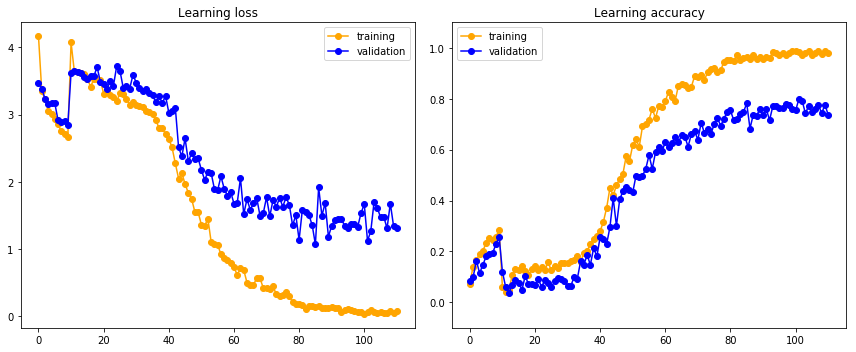

In [100]:
x = history['epoch']
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.title('Learning loss')
plt.plot(x, history['loss'], '-o', color='orange', label='training')
plt.plot(x, history['val_loss'], '-o', color='blue', label='validation')
plt.legend()
plt.subplot(122)
plt.title('Learning accuracy')
plt.plot(x, history['acc'], '-o', color='orange', label='training')
plt.plot(x, history['val_acc'], '-o', color='blue', label='validation')
plt.axis(ymin=-0.1, ymax=1.1)
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
!python3 /data/home/akbds/.local/lib/python3.5/site-packages/telegram_send.py 'Done training the model'

> Conclusions
- Option 1: Train only output fully-connected layers
    + Result: Validation accuracy reached 70% after 20 epochs
- Option 2: Warm up for a few epochs then unfreeze last conv block of VGG
    + Result: Validation accuracy almost hit 80% approaching 100 epochs
- Option 3: Train the full model without warmup
    + Result: Model didn't seem to converge after 80 epochs of training
- Option 4: Warm up fully-connected until stops learning then fine-tune the full model
    + Result: Significant drop in accuracy after unfreeze, model didn't converge
- Option 5: Warm up for a few epochs then unfreeze all of VGG
    + Result: Model could reach up to 60% accuracy at 60-th epoch
- Option 6: Warm up until stops learning then unfreeze last conv block of VGG
    + Result: Significant drop in metrics after unfreeze, didn't converge
    

Loss: categorical cross-entropy

Optimizer: Adam with starting learning rate at 0.001 and reduction by 2 if 5 consecutive epochs no imporve on validation loss with factor

Image size: 244

Network: VGG-16 with 2 fully-connected output layers